In [1]:
filename = "requirements.txt"
packs = """absl-py==2.3.0
certifi
charset-normalizer
clean-fid
colorama
contourpy
cycler
filelock
fonttools
fsspec
grpcio
h5py
idna
imageio
Jinja2
kiwisolver
lazy_loader
lightning-utilities
Markdown
MarkupSafe
matplotlib
mpmath
networkx
numpy
packaging
patchify
pillow
protobuf
pyparsing
python-dateutil
requests
scikit-image
scipy
six
sympy
tensorboard
tensorboard-data-server
tifffile
torch
torch-fidelity
torchaudio
torchmetrics
torchvision
tqdm
typing_extensions
urllib3
Werkzeug
"""

with open(filename,'w')as f:
  f.write(packs)

In [2]:
!pip install -r requirements.txt

In [3]:
import json
import os
import random
import tempfile
from pathlib import Path
import sys
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
import zipfile
import uuid
import requests
from tqdm import tqdm
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from PIL import Image, ImageDraw, ImageFont       # For drawing text and making collages
import torchvision.transforms.functional as TF   # For tensor ↔ image conversion
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import vgg19, VGG19_Weights
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from torchvision.utils import save_image
from torchmetrics.image.fid import FrechetInceptionDistance

In [4]:
#################### Models ########################

#==================== SRCNN Model =========================
class SRCNN(nn.Module):
    """ Vanilla model of SRCNN with 3 conv layers. """

    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x
#==========================================================

#================== SvOcSRCNN Model ========================
class SvOcSRCNN(nn.Module):
    def __init__(self):
        super(SvOcSRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),  # same as SRCNN
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 3, kernel_size=5, padding=2)  # Output layer
        )

    def forward(self, x):
        return self.model(x)
#===========================================================

#================ VDSR_Attention Model =====================
class VDSR_SA(nn.Module):
    def __init__(self, num_channels=3, num_features=64, num_resblocks=18):
        super().__init__()
        self.input_conv = nn.Conv2d(num_channels, num_features, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.resblocks = nn.Sequential(
            *[ResidualBlockSA(num_features) for _ in range(num_resblocks)]
        )
        self.output_conv = nn.Conv2d(num_features, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.relu(self.input_conv(x))
        out = self.resblocks(out)
        out = self.output_conv(out)
        return out + x  # residual learning

class ResidualBlockSA(nn.Module):
    def __init__(self, num_features=64):
        super().__init__()
        self.conv1 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        self.sa = SpatialAttention(kernel_size=7)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.sa(out)
        return x + out


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2

        # Compress channels using max-pool and avg-pool and concatenate
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply max-pool and avg-pool along channel axis (dim=1)
        max_pool = torch.max(x, dim=1, keepdim=True)[0]
        avg_pool = torch.mean(x, dim=1, keepdim=True)

        pool = torch.cat([max_pool, avg_pool], dim=1)  # shape (B, 2, H, W)
        attention = self.sigmoid(self.conv(pool))      # shape (B, 1, H, W)
        return x * attention
#===========================================================

In [5]:
#################### Data ########################

#================== DIV2K dataset class ==================
class DIV2KDataset(Dataset):
    def __init__(self, hr_folder, scale=2):
        self.hr_folder = hr_folder
        self.hr_files = sorted([f for f in os.listdir(hr_folder) if f.endswith('.png')])
        self.scale = scale
        self.hr_transform = transforms.Compose([
            transforms.Resize((256, 256)),   # Resize all HR images to same size
            transforms.ToTensor()
        ])
        self.lr_transform = transforms.Compose([
            transforms.Resize((128, 128), interpolation=Image.BICUBIC),  # Downscale
            transforms.Resize((256, 256), interpolation=Image.BICUBIC),  # Upscale
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hr_files)

    def __getitem__(self, idx):
        hr_image = Image.open(os.path.join(self.hr_folder, self.hr_files[idx])).convert('RGB')
        hr_tensor = self.hr_transform(hr_image)
        lr_tensor = self.lr_transform(hr_image)
        return lr_tensor, hr_tensor
#===========================================================

#================== DIV2K functions ==================
def download_div2k(destination="data"):
    os.makedirs(destination, exist_ok=True)
    url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
    filename = os.path.join(destination, "DIV2K_train_HR.zip")

    if not os.path.exists(filename):
        print("Downloading DIV2K...")
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(filename, 'wb') as f:
                for chunk in tqdm(r.iter_content(chunk_size=8192), desc="Downloading"):
                    f.write(chunk)
    else:
        print("DIV2K already downloaded.")

    # Extract
    extract_path = os.path.join(destination, "DIV2K_train_HR")
    if not os.path.exists(extract_path):
        print("Extracting DIV2K...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(destination)
        print("Done.")
    else:
        print("DIV2K already extracted.")

def save_batch_as_images(batch_tensor, root_dir):
    """Save a batch of images to the specified directory."""
    for i, img in enumerate(batch_tensor):
        img = img.clamp(0, 1).cpu()
        vutils.save_image(img, os.path.join(root_dir, f"{uuid.uuid4().hex}.png"))

#===========================================================


In [6]:
#====================== Metric utils =========================

def compute_psnr(sr: torch.Tensor, hr: torch.Tensor, data_range=1.0) -> float:
    """
    Compute average PSNR between super-resolved and high-res images.
    Args:
        sr: Super-resolved image tensor [B, C, H, W]
        hr: High-res ground truth tensor [B, C, H, W]
    Returns:
        PSNR value averaged over the batch
    """
    sr_np = sr.detach().cpu().numpy()
    hr_np = hr.detach().cpu().numpy()
    psnr = 0.0
    for i in range(sr_np.shape[0]):
        psnr += peak_signal_noise_ratio(hr_np[i].transpose(1, 2, 0),
                                        sr_np[i].transpose(1, 2, 0),
                                        data_range=data_range)
    return psnr / sr_np.shape[0]

def compute_ssim_batch(sr: torch.Tensor, hr: torch.Tensor, data_range=1.0) -> float:
    """
    Compute average SSIM over a batch.
    Args:
        sr: Super-resolved tensor [B, C, H, W]
        hr: High-res ground truth tensor [B, C, H, W]
    Returns:
        Average SSIM value over batch
    """
    sr_np = sr.detach().cpu().numpy()
    hr_np = hr.detach().cpu().numpy()
    ssim = 0.0
    for i in range(sr_np.shape[0]):
        ssim += structural_similarity(hr_np[i].transpose(1, 2, 0),
                                    sr_np[i].transpose(1, 2, 0),
                                    channel_axis=2,
                                    data_range=data_range)
    return ssim / sr_np.shape[0]

#===========================================================

In [7]:
#====================== Plot utils =========================
def annotate_image(tensor_img, text):
    img = TF.to_pil_image(tensor_img.squeeze(0).cpu())
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except:
        font = ImageFont.load_default()
    draw.text((5, 5), text, fill="white", font=font)
    return TF.to_tensor(img)

def create_collage(images, save_path):
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    collage = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for img in images:
        collage.paste(img, (x_offset, 0))
        x_offset += img.size[0]
    collage.save(save_path)


# === Training Curves Plot ===
def plot_training_curves(history, save_path=None):

    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    if 'val_loss' in history:
        plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.plot(epochs, history['val_psnr'], label='Val PSNR')
    plt.plot(epochs, history['val_ssim'], label='Val SSIM')
    if any(history.get('val_fid', [])):
        plt.plot(epochs, [fid if fid is not None else np.nan for fid in history['val_fid']], label='Val FID')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.title("Training Curves")
    if save_path:
        plt.savefig(save_path)
    plt.show()

#===========================================================

In [8]:
#====================== Loss Functions =========================
class PerceptualLoss(nn.Module):
    def __init__(self, resize=True, device='cpu'):
        super().__init__()
        vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features[:16].eval().to(device)
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.transform = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        self.resize = resize

    def forward(self, sr, hr):
        sr = self.transform(sr.clamp(0, 1))
        hr = self.transform(hr.clamp(0, 1))
        if self.resize:
            sr = F.interpolate(sr, size=(224, 224), mode='bilinear', align_corners=False)
            hr = F.interpolate(hr, size=(224, 224), mode='bilinear', align_corners=False)
        f1 = self.vgg(sr)
        f2 = self.vgg(hr)
        return F.l1_loss(f1, f2)


class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.8, resize=True, device='cpu'):
        super().__init__()
        self.perceptual = PerceptualLoss(resize=resize, device=device)
        self.alpha = alpha

    def forward(self, sr, hr):
        l1 = F.l1_loss(sr, hr)
        perceptual = self.perceptual(sr, hr)
        return self.alpha * l1 + (1 - self.alpha) * perceptual

#===========================================================

In [9]:
#====================== Plot utils =========================

def convert_to_builtin(obj):
    if isinstance(obj, dict):
        return {k: convert_to_builtin(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_builtin(i) for i in obj]
    elif isinstance(obj, np.generic):
        return obj.item()
    else:
        return obj

def train_val_test(model: nn.Module,
        train_loader,
        val_loader,
        test_loader,
        loss_fn=nn.MSELoss(),
        optimizer_cls=torch.optim.Adam,
        lr=1e-4,
        num_epochs=20,
        device=None,
        save_dir=None,
        verbose=True,
        val_fid_interval=5):

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optimizer_cls(model.parameters(), lr=lr)
    best_val_psnr = 0
    history = {'train_loss': [], 'val_psnr': [], 'val_ssim': [], 'val_fid': []}

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for lr_img, hr_img in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)
            optimizer.zero_grad()
            output = model(lr_img)
            loss = loss_fn(output, hr_img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        psnr_list, ssim_list = [], []
        with torch.no_grad():
            for lr_img, hr_img in val_loader:
                lr_img, hr_img = lr_img.to(device), hr_img.to(device)
                output = model(lr_img)
                psnr = compute_psnr(output, hr_img)
                ssim = compute_ssim_batch(output, hr_img)
                psnr_list.append(psnr)
                ssim_list.append(ssim)

        val_psnr = np.mean(psnr_list)
        val_ssim = np.mean(ssim_list)
        history['val_psnr'].append(val_psnr)
        history['val_ssim'].append(val_ssim)

        # Optional FID computation on validation
        if (epoch + 1) % val_fid_interval == 0:
            fid_metric = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
            with tempfile.TemporaryDirectory() as tmpdir:
                for lr_img, hr_img in val_loader:
                    lr_img, hr_img = lr_img.to(device), hr_img.to(device)
                    with torch.no_grad():
                        sr_img = model(lr_img)
                    sr_resized = F.interpolate(sr_img, size=(299, 299), mode='bilinear', align_corners=False)
                    hr_resized = F.interpolate(hr_img, size=(299, 299), mode='bilinear', align_corners=False)
                    fid_metric.update(sr_resized, real=False)
                    fid_metric.update(hr_resized, real=True)
                val_fid = fid_metric.compute().item()
                history['val_fid'].append(val_fid)
                if verbose:
                    print(f"Val FID (epoch {epoch+1}): {val_fid:.4f}")
        else:
            history['val_fid'].append(None)

        if verbose:
            print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val PSNR={val_psnr:.2f}, SSIM={val_ssim:.4f}")

        if save_dir and val_psnr > best_val_psnr:
            best_val_psnr = val_psnr
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))

    # Final test evaluation including FID and selective image saving
    model.eval()
    psnr_list, ssim_list = [], []

    # Save only N examples
    N = 10
    example_indices = random.sample(range(len(test_loader.dataset)), N) if len(test_loader.dataset) >= N else list(range(len(test_loader.dataset)))
    saved_idx = 0

    collage_dir = Path(save_dir) / "collages"
    collage_dir.mkdir(parents=True, exist_ok=True)

    temp_out = Path(tempfile.mkdtemp()) / "output"
    temp_gt = Path(tempfile.mkdtemp()) / "gt"
    temp_out.mkdir(parents=True, exist_ok=True)
    temp_gt.mkdir(parents=True, exist_ok=True)

    with torch.no_grad():
        for idx, (lr_img, hr_img) in enumerate(test_loader):
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)
            output = model(lr_img)
            psnr = compute_psnr(output, hr_img)
            ssim = compute_ssim_batch(output, hr_img)
            psnr_list.append(psnr)
            ssim_list.append(ssim)

            save_image(output.clamp(0, 1), temp_out / f"{idx:05d}.png")
            save_image(hr_img.clamp(0, 1), temp_gt / f"{idx:05d}.png")

            if idx in example_indices:
                caption = f"PSNR: {psnr:.2f}, SSIM: {ssim:.4f}"
                lr_annot = annotate_image(lr_img, caption)
                sr_annot = annotate_image(output, caption)
                hr_annot = annotate_image(hr_img, caption)

                collage = [TF.to_pil_image(t.squeeze(0).cpu()) for t in [lr_annot, sr_annot, hr_annot]]
                collage_path = collage_dir / f"{saved_idx:05d}_PSNR{psnr:.2f}_SSIM{ssim:.4f}.png"
                create_collage(collage, collage_path)

                saved_idx += 1

    fid_metric = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
    with torch.no_grad():
        for fname in sorted(os.listdir(temp_out)):
            sr_img = Image.open(temp_out / fname).convert('RGB')
            hr_img = Image.open(temp_gt / fname).convert('RGB')

            sr_tensor = TF.to_tensor(sr_img).unsqueeze(0).to(device)
            hr_tensor = TF.to_tensor(hr_img).unsqueeze(0).to(device)

            sr_tensor = F.interpolate(sr_tensor, size=(299, 299), mode='bilinear', align_corners=False)
            hr_tensor = F.interpolate(hr_tensor, size=(299, 299), mode='bilinear', align_corners=False)

            fid_metric.update(sr_tensor, real=False)
            fid_metric.update(hr_tensor, real=True)

    fid_score = fid_metric.compute().item()

    final_metrics = {
        'test_psnr': float(np.mean(psnr_list)),
        'test_ssim': float(np.mean(ssim_list)),
        'test_fid': float(fid_score)
    }

    if verbose:
        print("\n=== Final Test Metrics ===")
        print("PSNR:", final_metrics['test_psnr'])
        print("SSIM:", final_metrics['test_ssim'])
        print("FID :", final_metrics['test_fid'])

    if save_dir:
        with open(os.path.join(save_dir, 'metrics.json'), 'w') as f:
            json.dump(convert_to_builtin({**history, **final_metrics}), f, indent=2)

    return model, history, final_metrics

#===========================================================

Preparing DIV2K dataset...
DIV2K already downloaded.
DIV2K already extracted.
Training SRCNN model...


Epoch 1/1: 100%|██████████| 160/160 [01:43<00:00,  1.55it/s]


Epoch 1: Train Loss=0.0269, Val PSNR=24.02, SSIM=0.7793


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 45.8MB/s]



=== Final Test Metrics ===
PSNR: 24.23607487337633
SSIM: 0.7851055033504963
FID : 134.71890258789062
Training complete. SRCNN model saved.
Test metrics: {'test_psnr': 24.23607487337633, 'test_ssim': 0.7851055033504963, 'test_fid': 134.71890258789062}


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 98.4MB/s]


Training SvOcSRCNN model...


Epoch 1/1: 100%|██████████| 160/160 [01:58<00:00,  1.35it/s]


Epoch 1: Train Loss=0.4738, Val PSNR=19.40, SSIM=0.7270

=== Final Test Metrics ===
PSNR: 19.911007573037278
SSIM: 0.7375214904546737
FID : 195.21241760253906
Training complete. SvOcSRCNN model saved.
Test metrics: {'test_psnr': 19.911007573037278, 'test_ssim': 0.7375214904546737, 'test_fid': 195.21241760253906}
Training VDSR_SA model...


Epoch 1/1: 100%|██████████| 160/160 [03:10<00:00,  1.19s/it]


Epoch 1: Train Loss=0.0019, Val PSNR=29.55, SSIM=0.9147

=== Final Test Metrics ===
PSNR: 29.453135066497584
SSIM: 0.9152522288262844
FID : 56.45594787597656
Training complete. VDSR_SA model saved.
Test metrics: {'test_psnr': 29.453135066497584, 'test_ssim': 0.9152522288262844, 'test_fid': 56.45594787597656}


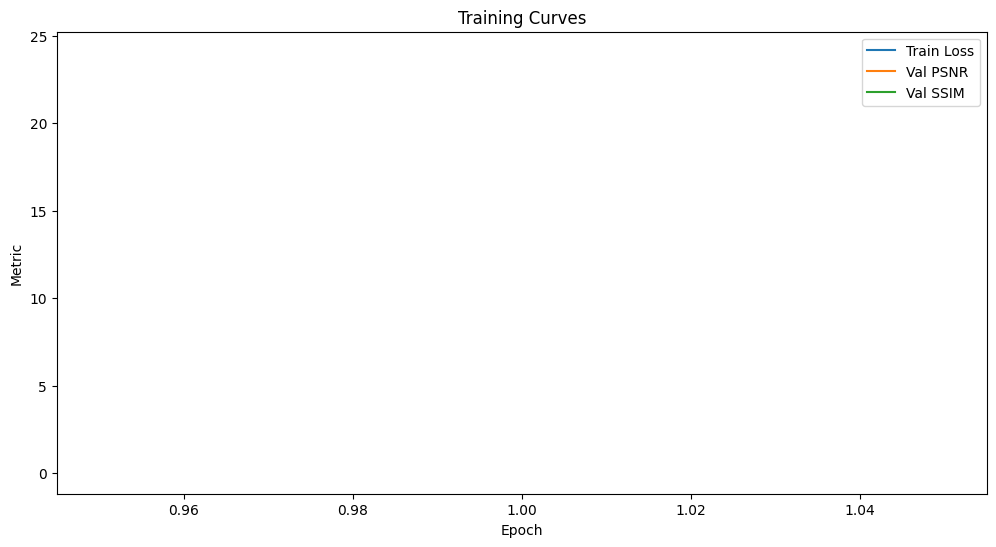

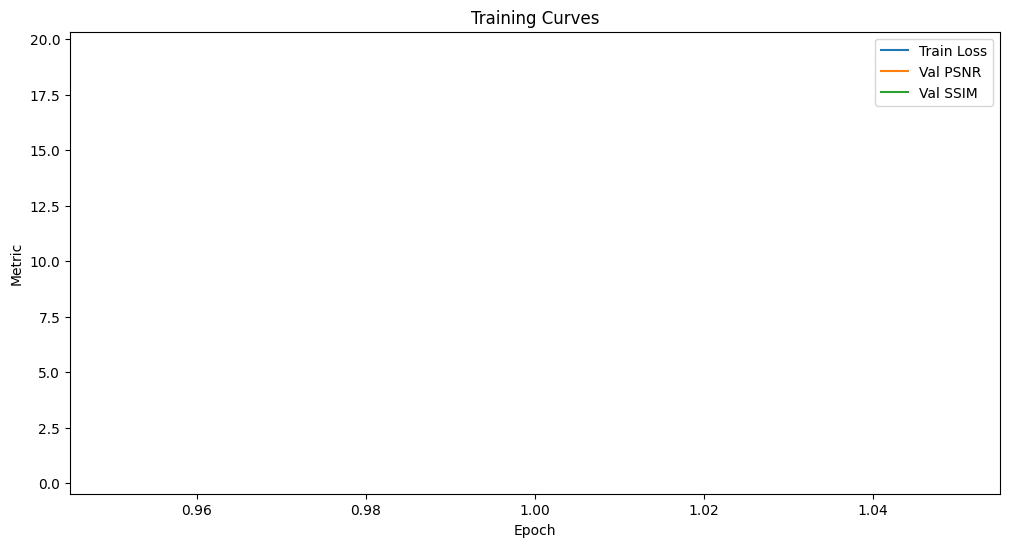

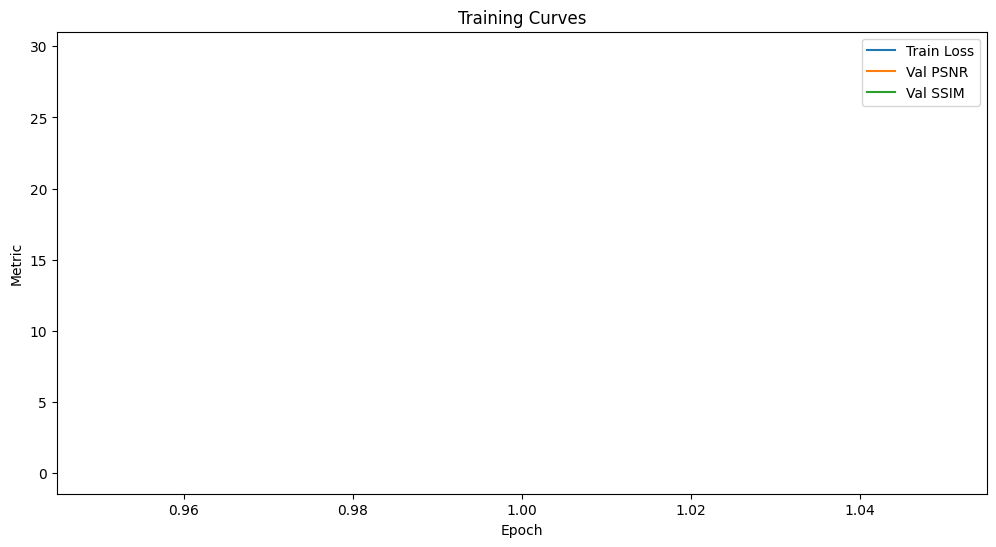

In [10]:
#====================== Main =========================

#sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.append(os.getcwd())

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {}
    download_div2k_flag = True # Change to false if already downloaded the dataset

    # Step 1: Download and prepare dataset
    if download_div2k_flag:
        print("Preparing DIV2K dataset...")
        download_div2k("Data")
    full_dataset = DIV2KDataset("Data/DIV2K_train_HR", scale=2)

    # Split dataset into train/val/test
    total_size = len(full_dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Step 2: Train SRCNN model
    print("Training SRCNN model...")
    srcnn = SRCNN().to(device)
    # Use plain MSE loss
    loss_fn = nn.MSELoss()

    trained_srcnn_model, srcnn_history, srcnn_test_metrics = train_val_test(
        model=srcnn,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        loss_fn=loss_fn,
        save_dir="checkpoints/srcnn_mse",
        num_epochs=1,
        lr=1e-4
    )
    print("Training complete. SRCNN model saved.")
    print("Test metrics:", (srcnn_test_metrics))

    # Step 3: Train SvOcSRCNN model
    model = SvOcSRCNN()
    loss_fn = CombinedLoss(alpha=0.8, device=device)
    print("Training SvOcSRCNN model...")
    trained_SvOcSRCNN_model, SvOcSRCNN_history, SvOcSRCNN_test_metrics = train_val_test(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        loss_fn=loss_fn,
        save_dir="checkpoints/svoc-perceptual",
        num_epochs=1
    )
    print("Training complete. SvOcSRCNN model saved.")
    print("Test metrics:", (SvOcSRCNN_test_metrics))

    # Step 4: Train VDSR_SA model
    print("Training VDSR_SA model...")
    vdsr_model = VDSR_SA().to(device)
    loss_fn = nn.MSELoss()
    tained_vdsr_model, vdsr_history, vdsr_test_metrics = train_val_test(
        model=vdsr_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        loss_fn=loss_fn,
        save_dir="checkpoints/vdsr_sa",
        num_epochs=1,
        lr=1e-4
    )
    print("Training complete. VDSR_SA model saved.")
    print("Test metrics:", (vdsr_test_metrics))


    plot_training_curves(srcnn_history, "checkpoints/srcnn_mse/training_plot.png")
    plot_training_curves(SvOcSRCNN_history, "checkpoints/svoc-perceptual/training_plot.png")
    plot_training_curves(vdsr_history, "checkpoints/vdsr_sa/training_plot.png")

main()

#=====================================================